In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
# import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

2023-03-18 14:32:17.789335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 14:32:18.867670: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-18 14:32:18.867786: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-18 14:32:18.867794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [46]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bkapteijns/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bkapteijns/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bkapteijns/nltk_data...


True

In [3]:
train_df = pd.read_table("2013_Queensland_Floods_train.tsv")
test_df = pd.read_table("2013_Queensland_Floods_test.tsv")
col_names = train_df.columns
train_df["text"]

0       I just though about the night I went clubbing ...
1       Looks like its going to be another long night ...
2       @LaniiBanani hahahaha I just told him id have ...
3       Off to meeting.... with so called... Baaps of ...
4                Doubt I'll be getting much sleep tonight
                              ...                        
6014    RT @GrillTeam: The Queensland government has s...
6015    Can we have 5 NEMA staff from Nigeria  come to...
6016    RT @7NewsBrisbane: Foam from rough waves at Al...
6017    RT @abcsouthqld: Master Electricians Australia...
6018    RT @HomeLoanKing: Leader of Aussie opposition,...
Name: text, Length: 6019, dtype: object

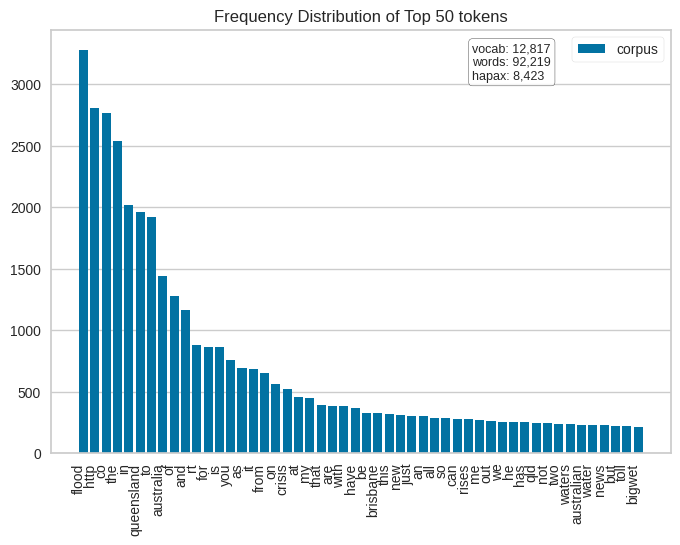

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [4]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(train_df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [5]:
train_text = train_df["text"]
train_labels = train_df["label"]

test_text = test_df["text"]
test_labels = test_df["label"]

print(train_text.shape)
print(test_text.shape)

(6019,)
(3011,)


In [6]:
# remove digits, @-mentions, links, stopwords

train_text = train_text.str.lower()
#train_text = train_text.apply(lambda elem: re.sub(r"\d+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
train_text = train_text.apply(lambda x : nltk.word_tokenize(x))
train_text = train_text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

test_text = test_text.str.lower()
#test_text = test_text.apply(lambda elem: re.sub(r"\d+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
test_text = test_text.apply(lambda x : nltk.word_tokenize(x))
test_text = test_text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

train_text.shape

(6019,)

In [7]:
# include the hashtag anyway because #savehaiti is different from savehaiti
train_text = train_text.apply(lambda elem: re.sub(r"#", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\.", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\,", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\?", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\!", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\:", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\;", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\-", " ", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\'", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\_", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\/", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\*", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\%", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\&", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\\", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@\s[a-zA-Z0-9]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\$", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\[", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\]", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\~", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\(", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\)", "", elem))
train_text = train_text.apply(lambda elem: re.sub("http", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\s\s*", " ", elem))
train_text = train_text.apply(lambda elem: re.sub(r"^\s+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\s+$", "", elem))

test_text = test_text.apply(lambda elem: re.sub(r"#", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\.", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\,", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\?", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\!", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\:", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\;", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\-", " ", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\'", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\_", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\/", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\*", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\%", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\&", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\\", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"@\s[a-zA-Z0-9]+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"@", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\$", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\[", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\]", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\~", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\(", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\)", "", elem))
test_text = test_text.apply(lambda elem: re.sub("http", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\s\s*", " ", elem))
test_text = test_text.apply(lambda elem: re.sub(r"^\s+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\s+$", "", elem))


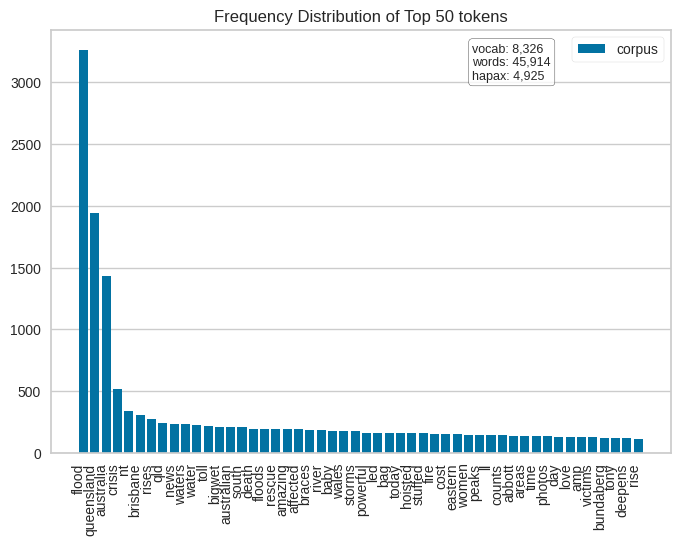

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [8]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(pd.DataFrame(train_text)["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

b'not_relevant' 	 0.46037547765409537
b'relevant' 	 0.5396245223459046


2023-03-18 14:48:57.351935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 14:49:00.949721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 97 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:21:00.0, compute capability: 7.0
2023-03-18 14:49:00.957711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1285 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:81:00.0, compute capability: 7.0


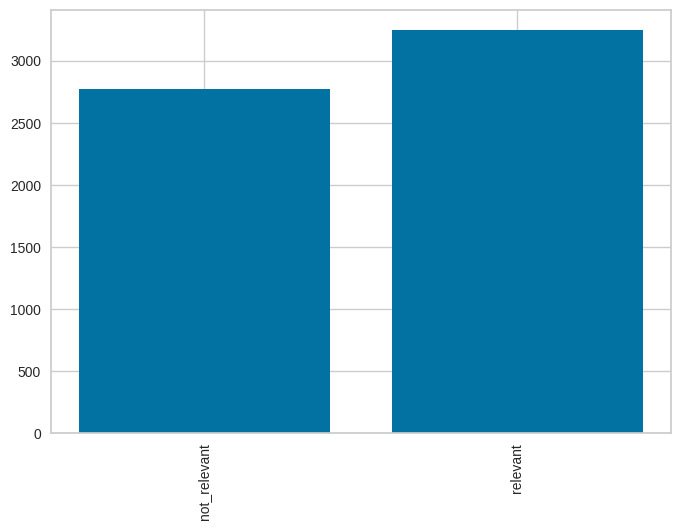

In [9]:
train_text = tf.convert_to_tensor(train_text)
train_labels = tf.convert_to_tensor(train_labels)

test_text = tf.convert_to_tensor(test_text)
test_labels = tf.convert_to_tensor(test_labels)

labels = tf.unique(train_labels)[0]
#print(np.array(tf.unique(train_labels)[1]))

for x in range(0,len(labels)):
  print(np.array(labels)[x], '\t', np.mean(x == tf.unique(train_labels)[1]))
plt.bar(np.array(labels), [np.sum(x == tf.unique(train_labels)[1]) for x in range(0,len(labels))])
plt.xticks(rotation = 90)
plt.show()

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
X_train, _, y_train, _ = train_test_split(np.array(train_text), np.array(train_labels), train_size=500, shuffle=True)
for i in range(len(X_train)):
  X_train[i] = str(X_train[i])[2:-1]
  X_train[i] = tokenizer.tokenize(X_train[i])
  X_train[i] = tokenizer.convert_tokens_to_ids(X_train[i])

X_test, _, y_test, _ = train_test_split(np.array(test_text), np.array(test_labels), train_size=100, shuffle=True)
for i in range(len(X_test)):
  X_test[i] = str(X_test[i])[2:-1]
  X_test[i] = tokenizer.tokenize(X_test[i])
  X_test[i] = tokenizer.convert_tokens_to_ids(X_test[i])

In [12]:
_X_test, _, _y_test, _ = train_test_split(np.array(test_text), np.array(test_labels), train_size=100, shuffle=True)

In [13]:
for i in range(len(_X_test)):
  _X_test[i] = str(_X_test[i])[2:-1]

In [14]:
print(_X_test[0])
print(tokenizer.tokenize(_X_test[0]))
tokenizer.convert_tokens_to_string(tokenizer.tokenize(_X_test[0]))

x complain type juice plane p
['x', 'complain', 'type', 'juice', 'plane', 'p']


'x complain type juice plane p'

In [15]:
import torch

max_length = 64
model.config.max_position_embeddings = max_length

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [16]:
print(X_train_padded)

tensor([[ 5322,  2740,  2304,  ...,     0,     0,     0],
        [ 4931,  3582,     0,  ...,     0,     0,     0],
        [11184,  3235,  3994,  ...,     0,     0,     0],
        ...,
        [ 6145,  2660,  7186,  ...,     0,     0,     0],
        [ 3393,  9856,  5602,  ...,     0,     0,     0],
        [ 1054,  2243,  2424,  ...,     0,     0,     0]])


In [17]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3617,  0.6612,  0.1784,  ..., -0.5433,  0.3972,  0.1870],
         [ 0.4511,  0.6270,  0.0571,  ..., -0.4152, -0.0437, -0.4625],
         [ 0.4039,  0.7357,  0.0450,  ..., -0.4678, -0.2332, -0.7046],
         ...,
         [ 0.5099,  0.4879,  0.5837,  ..., -0.4985,  0.7097,  0.2017],
         [ 0.4838,  0.4910,  0.5799,  ..., -0.4776,  0.7125,  0.2064],
         [ 0.4798,  0.5397,  0.5571,  ..., -0.4725,  0.6955,  0.1813]],

        [[-0.1989, -0.0122, -0.1742,  ..., -0.8593,  0.8330, -0.1088],
         [-0.0203, -0.0755, -0.1845,  ..., -0.7303,  0.5605, -0.0625],
         [-0.0697, -0.0785, -0.1959,  ..., -0.7835,  0.4288, -0.0804],
         ...,
         [-0.2516, -0.1156,  0.0808,  ..., -0.9785,  0.9238, -0.1937],
         [-0.2511, -0.0998,  0.0833,  ..., -0.9708,  0.9481, -0.1860],
         [-0.2398, -0.0628,  0.0633,  ..., -0.9662,  0.9490, -0.1840]],

        [[-0.2186,  0.1251, -0.0762,  ..., -0.7036,  

In [18]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 1.4061e-01,  4.1263e-02, -3.0122e-01,  ..., -6.5145e-01,
           8.1768e-01,  1.8048e-01],
         [ 1.2028e-01,  3.5142e-01, -4.4423e-01,  ..., -4.0435e-01,
           3.9012e-01,  1.3523e-01],
         [ 2.9763e-01,  4.2360e-01, -3.8145e-01,  ..., -4.3670e-01,
           3.0457e-01,  2.5355e-01],
         ...,
         [ 8.5623e-02, -5.8106e-02, -5.1468e-02,  ..., -6.8395e-01,
           8.9049e-01,  5.4394e-02],
         [ 8.2473e-02, -3.9869e-02, -5.3338e-02,  ..., -6.7715e-01,
           9.1657e-01,  6.1012e-02],
         [ 8.0328e-02,  1.0169e-02, -7.2470e-02,  ..., -6.7897e-01,
           9.3046e-01,  7.3405e-02]],

        [[-2.5533e-01, -5.0689e-02, -1.9380e-01,  ..., -8.1265e-01,
           7.0634e-01,  1.4285e-01],
         [-2.3906e-01,  2.6474e-02, -3.8333e-01,  ..., -5.6706e-01,
           4.1362e-01,  8.4563e-02],
         [-2.5245e-01,  9.8395e-02, -3.4595e-01,  ..., -5.2523e-01,
           3.

In [19]:
print(bert_train_output[0].shape, bert_train_output[1].shape)
print(bert_test_output[0].shape, bert_test_output[1].shape)
print(type(bert_train_output[0]))

torch.Size([500, 64, 768]) torch.Size([500, 768])
torch.Size([100, 64, 768]) torch.Size([100, 768])
<class 'torch.Tensor'>


In [20]:
train_sequence_output = bert_train_output[1].detach().numpy().copy()
X_train = train_sequence_output.reshape(X_train.shape[0], 768)

test_sequence_output = bert_test_output[1].detach().numpy().copy()
X_test = test_sequence_output.reshape(X_test.shape[0], 768)

bert_train_output = None
bert_test_output = None

In [21]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [22]:
clf = neural_network.MLPClassifier()
clf.fit(X_train, le.transform(y_train))

/home/bkapteijns/disaster-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [23]:
clf2 = neural_network.MLPClassifier()
clf2.fit(X_train_padded, le.transform(y_train))

/home/bkapteijns/disaster-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier()

In [24]:
print("Train accuracy:", np.mean(clf.predict(X_train) == le.transform(y_train)))
print("Test accuracy:", np.mean(clf.predict(X_test) == le.transform(y_test)))

Train accuracy: 0.944
Test accuracy: 0.86


## SHAP

In [26]:
import shap
shap.initjs()

In [27]:
to_explain = np.array(X_test_padded)[:10]

In [28]:
def prediction_model(X):
  bert_output = model(torch.from_numpy(np.array(X)).to(torch.int64))
  sequence_output = bert_output[1].detach().numpy()
  return clf.predict(sequence_output.reshape(X.shape[0], 768))

In [29]:
permutation_values = []
permutation_explainer = shap.explainers.Permutation(prediction_model, np.array(to_explain))
for i in range(len(to_explain)):
  permutation_values.append(permutation_explainer(np.array([to_explain[i]])))

Permutation explainer: 2it [02:19, 139.37s/it]                                                                                        
Permutation explainer: 2it [02:03, 124.00s/it]                                                                                        
Permutation explainer: 2it [02:00, 120.85s/it]                                                                                        
Permutation explainer: 2it [01:25, 85.71s/it]                                                                                         
Permutation explainer: 2it [01:23, 83.48s/it]                                                                                         
Permutation explainer: 2it [01:17, 77.11s/it]                                                                                         
Permutation explainer: 2it [01:22, 82.09s/it]                                                                                         
Permutation explainer: 2it [01:29, 89.89s/it]          

In [31]:
perm_vals = {"values": [], "base_values": [], "data": []}
for pv in permutation_values:
    perm_vals["values"].append(pv.values[0])
    perm_vals["base_values"].append(pv.base_values[0])
    perm_vals["data"].append(pv.data[0])

Sentence: ah ##mar dead dozens plucked roofs maroon ##ed cars air rescues northeastern australia severe flood ; Prediction: [1] ; True value: b'relevant'


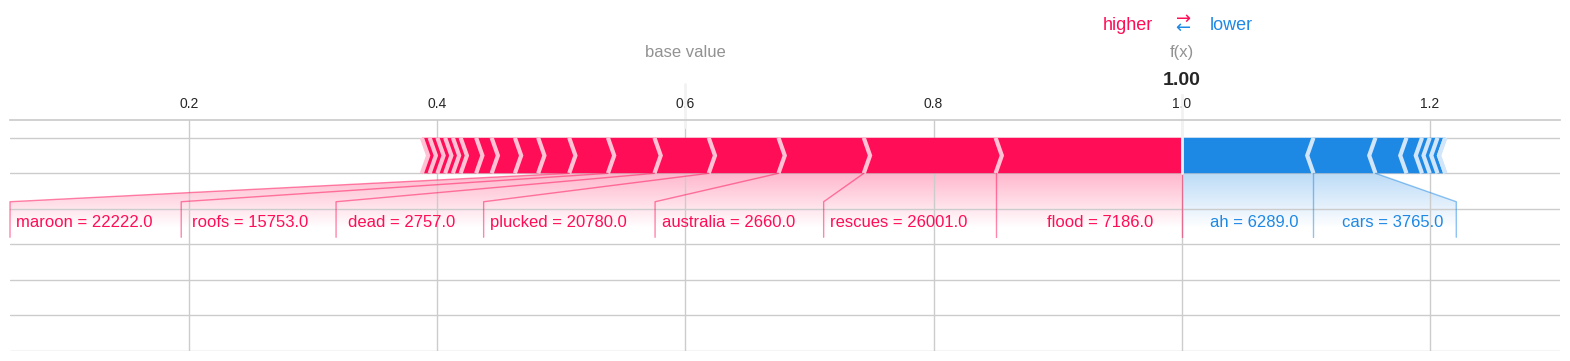

Sentence: flood barrier set australia 1st brisbane ; Prediction: [1] ; True value: b'relevant'


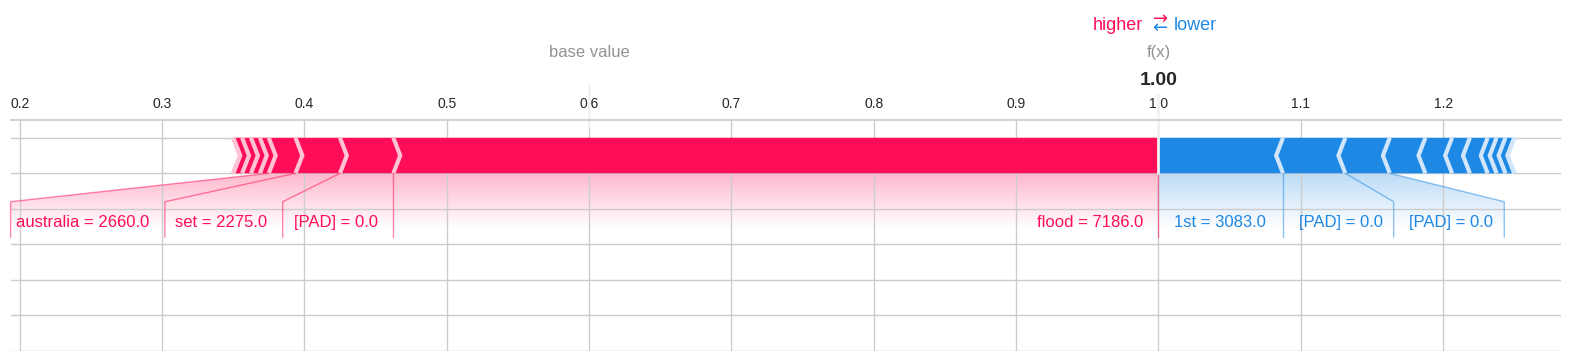

Sentence: wanted today raining beer ha ##gg ##is whisky ; Prediction: [0] ; True value: b'not_relevant'


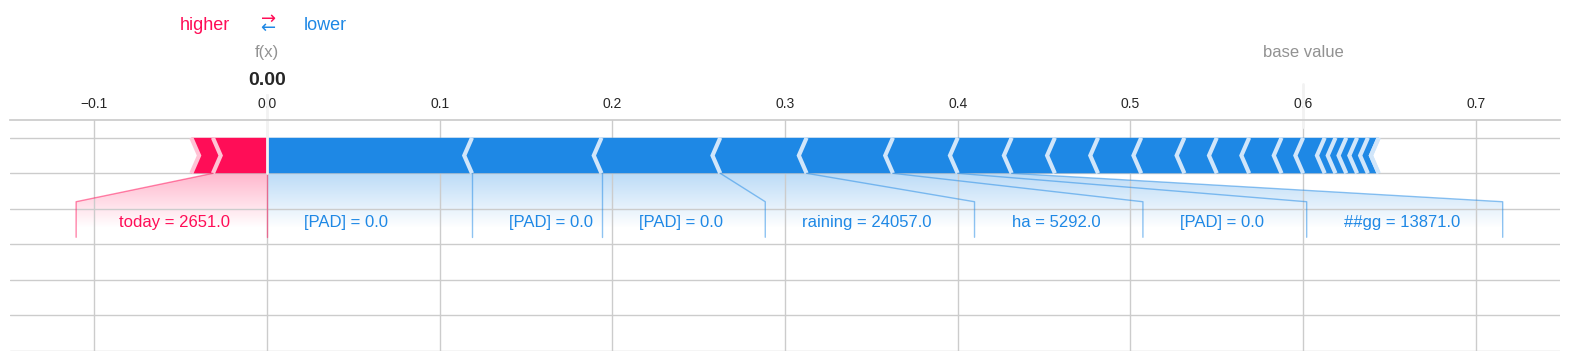

Sentence: m boo ##ra ##bb ##in picnic ground ; Prediction: [0] ; True value: b'not_relevant'


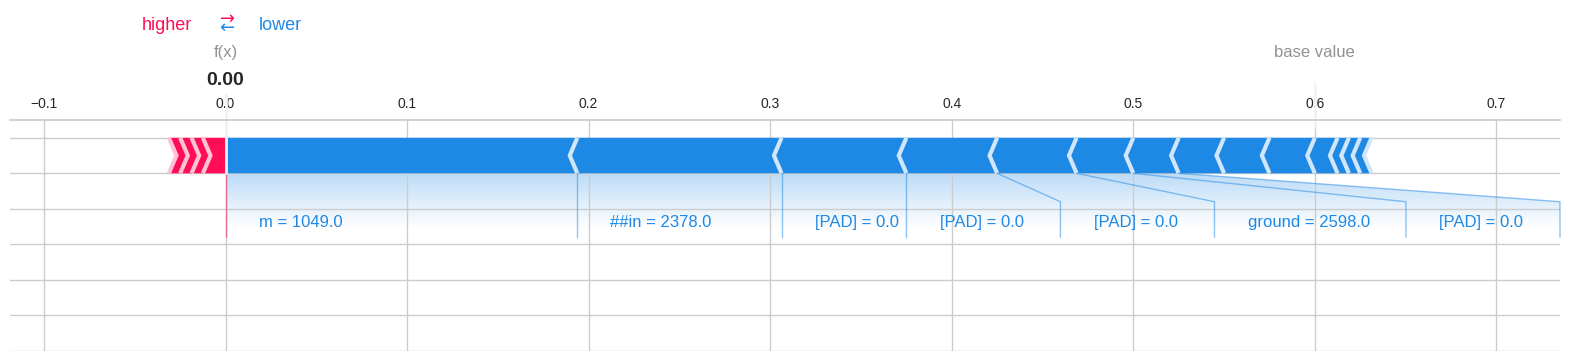

Sentence: premier campbell newman aims flood proof towns wake queensland herald sun q ##ld ; Prediction: [1] ; True value: b'relevant'


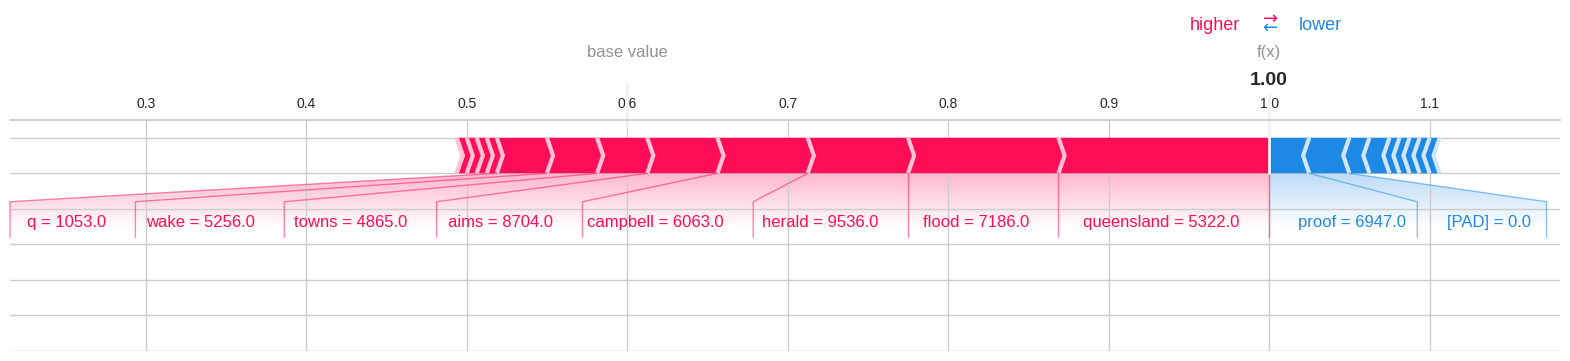

Sentence: awesome applying year m australia atm go ##n apply year ; Prediction: [0] ; True value: b'not_relevant'


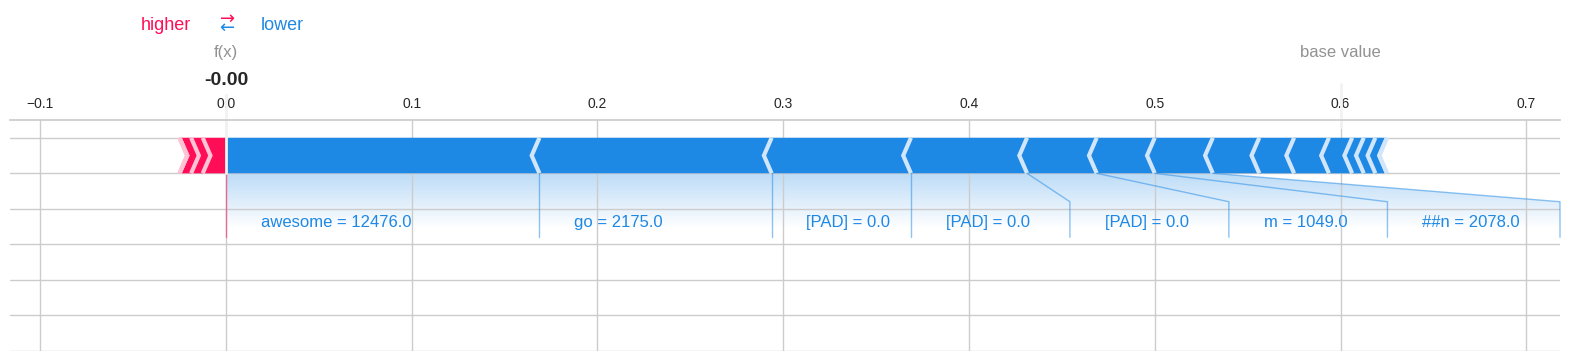

Sentence: thousands forced evacuate flooding eastern australia thousands forced evacuate homes due flood ; Prediction: [1] ; True value: b'relevant'


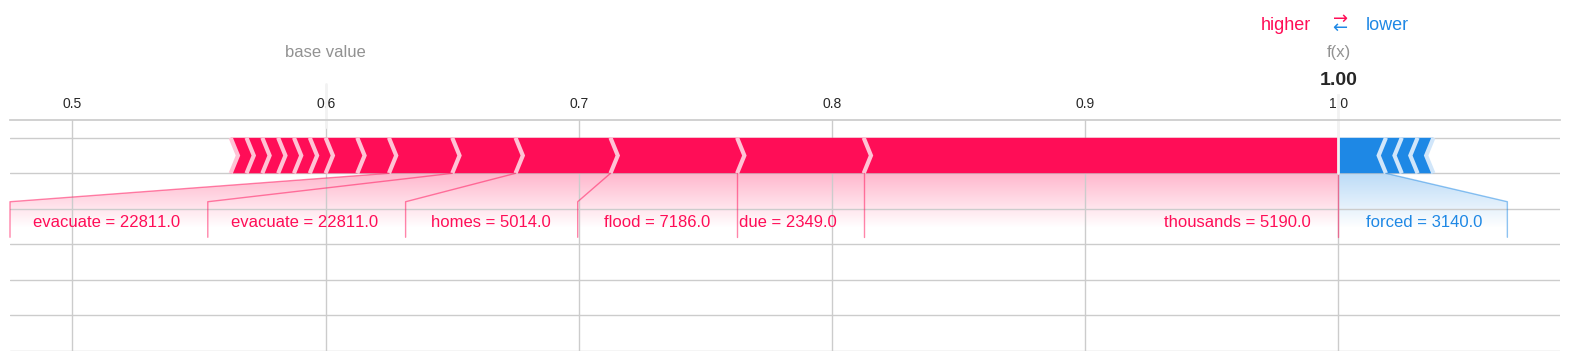

Sentence: frustration ##s grow lack assistance flood waters rec ##ede australia s queensland state rao ##nai ##r ; Prediction: [1] ; True value: b'relevant'


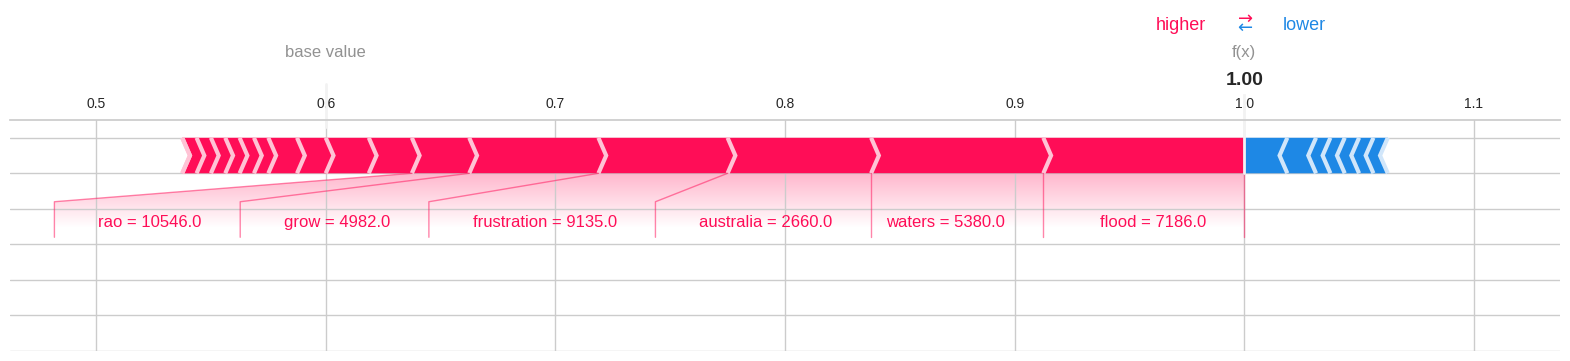

Sentence: th ##u jan 31 2013 120 ##7 ##18 gm ##t ##00 ##00 utc mod ##is flood map server processed 140 ##e ##0 ##20 ##s date 2013 03 ##1 ; Prediction: [0] ; True value: b'not_relevant'


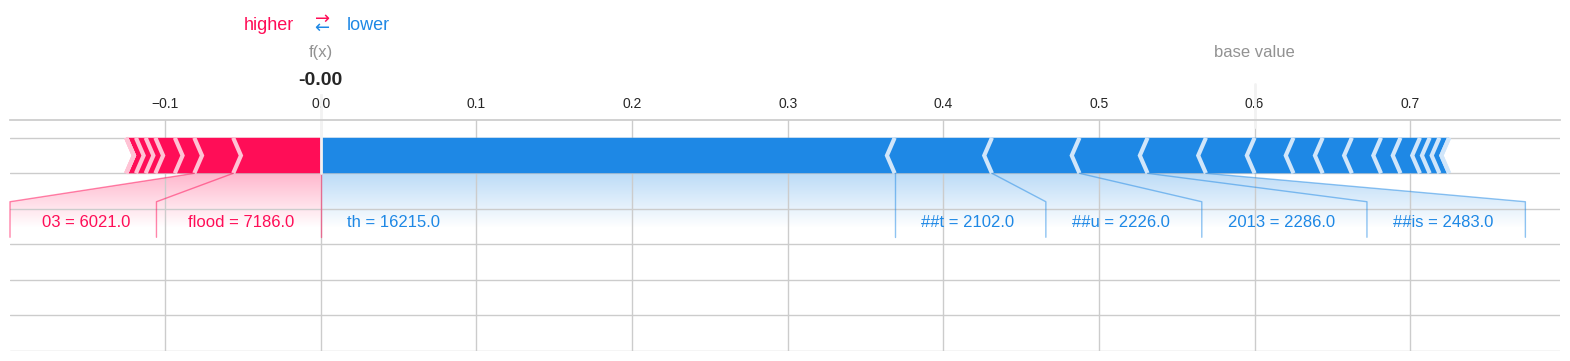

Sentence: vo ##da ##fo ##ne restoring 2 ##g 3 ##g services flood affected queensland vo ##da ##fo ##ne process restoring 2 ##g ; Prediction: [1] ; True value: b'relevant'


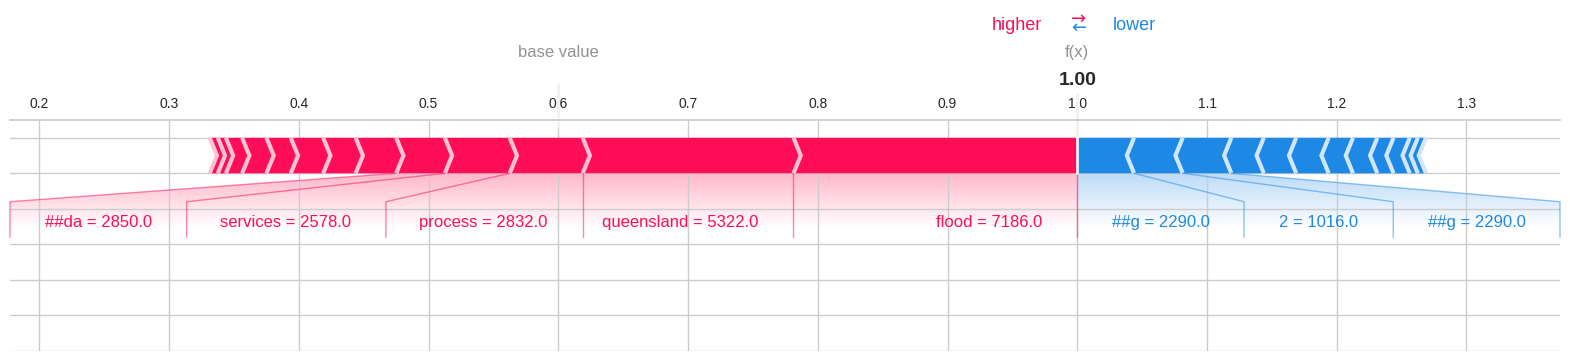

In [32]:
for i in range(len(to_explain)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(to_explain[i])).replace(" [PAD]", "") ,"; Prediction:", prediction_model(np.array([to_explain[i]])), "; True value:", y_test[i])
  shap.plots.force(perm_vals["base_values"][i], perm_vals["values"][i], perm_vals["data"][i], feature_names=tokenizer.convert_ids_to_tokens(perm_vals["data"][i]), matplotlib=True)

In [33]:
import copy
heatmaps = np.array(copy.copy(perm_vals["values"]))
heatmaps += perm_vals["base_values"][0]/64
for i in range(len(heatmaps)):
  print(np.sum(heatmaps[i]))

0.9999999999999998
1.0
-6.938893903907228e-17
-2.7755575615628914e-17
0.9999999999999999
-9.020562075079397e-17
1.0
0.9999999999999998
-2.7755575615628914e-17
1.0000000000000002


Prediction: positive


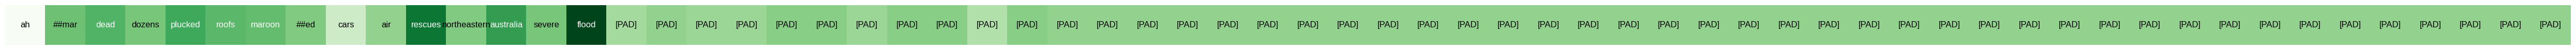

Prediction: positive


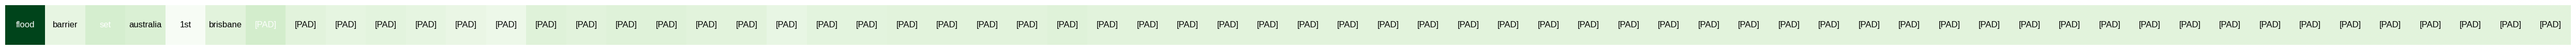

Prediction: negative


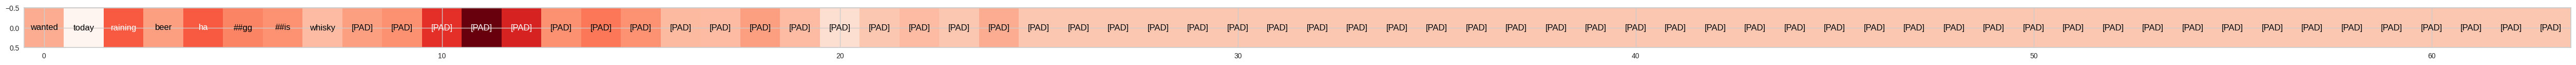

Prediction: negative


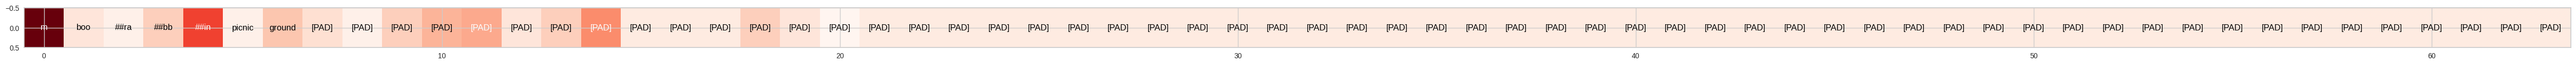

Prediction: positive


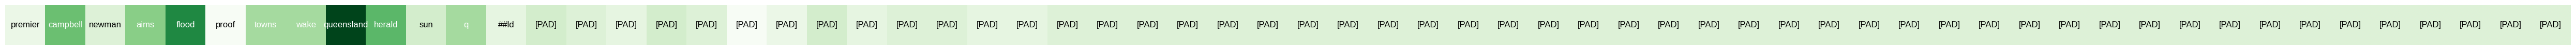

Prediction: negative


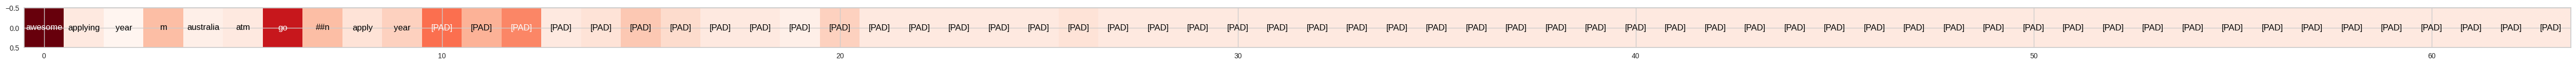

Prediction: positive


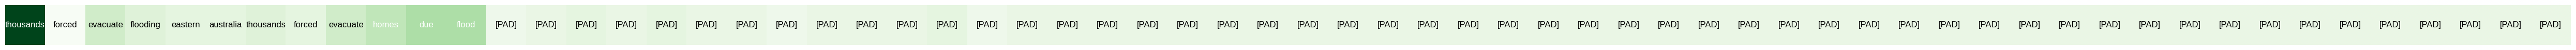

Prediction: positive


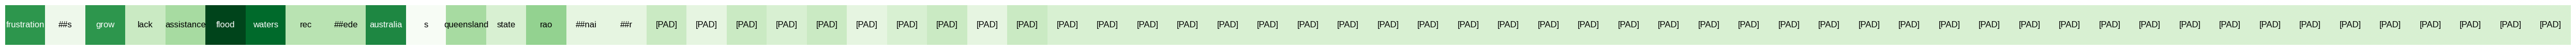

Prediction: negative


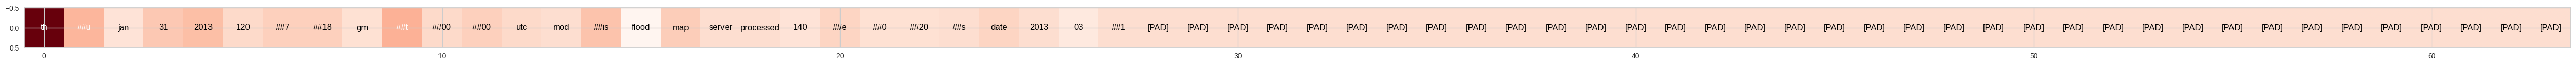

Prediction: positive


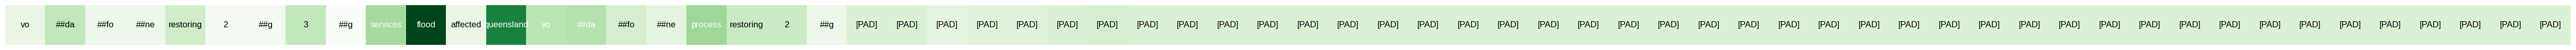

In [34]:
for x in range(len(to_explain)):
  fig, ax = plt.subplots(figsize=(len(to_explain[x]), 1))
  if prediction_model(np.array([to_explain[x]]))[0] == 0:
    print("Prediction: negative")
    ax.imshow([-heatmaps[x]], cmap="Reds", aspect="auto")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] < -0.04 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))
  else:
    print("Prediction: positive")
    ax.imshow([heatmaps[x]], cmap="Greens", aspect="auto")
    ax.axis("off")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] > 0.04 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))


  plt.show()

In [47]:
def ablate(x, i):
  x[i] = 0
  for j in range(i, len(x)-1):
    x[j] = x[j+1]
  x[-1] = 0
  return x
def compute_contrast(X, model, explanation):
  contrast = [0]*len(X)
  for i in range(len(X)):
    old_prediction = model(np.array([X[i]]))
    for j in range(len(X[i])):
      x = ablate(copy.deepcopy(X[i]), j)
      new_prediction = model(np.array([x]))
      if (new_prediction != old_prediction):
        contrast[i] += explanation[i][j]
  return contrast

In [48]:
def compute_distinctiveness(data, train_data, explanation):
  distinctiveness = [0] * len(data)

  frequencies = []
  for x in np.unique(train_data):
    frequencies.append((np.mean(np.array(train_data) == x), x))
  sorted_frequencies = sorted(frequencies)
  word_specialty = {0: 0}
  for i, (f, x) in enumerate(sorted_frequencies):
    word_specialty[x] = 1 - i / len(sorted_frequencies)

  for i in range(len(data)):
    for j in range(len(data[i])):
      try:
        distinctiveness[i] += word_specialty[data[i][j]] * explanation[i][j]
      except:
        distinctiveness[i] += explanation[i][j]

  return distinctiveness

In [65]:
import copy
def compute_fidelity(X, explanation, model):
    fidelity = [0] * len(X)
    samples = 5
    for i in range(len(X)):
        change_ratings = [0]*len(X[i])
        x = 0
        while x < len(X[i]):
            print(x)
            change_rating = 0
            for change in range(samples):
                new_X = copy.deepcopy(X[i])
                new_X[x] = new_X[x] + (100 * change / samples)
                if (model(np.array([X[i]])) == model(np.array([new_X]))):
                    change_rating += 1/samples
            change_ratings[x] = change_rating
            if (X[i][x] == 0):
                x = len(X[i])
            x += 1
            
        for j in range(len(X[i])):
            fidelity[i] += change_ratings[j] * explanation[i][j]
    return fidelity

In [50]:
from nltk.corpus import wordnet as wn
def compute_realism(data, id_to_token, topic, explanation):
  """
  data: the word ids in the shape of #elements x #words
  topic: a wordnet synset
  id_to_token: a function from ids to tokens

  returns an array of length #elements
  """
  metrics = [0] * len(data)
  for i in range(len(data)):
    for j in range(len(data[i])):
      try:
        metrics[i] += explanation[i][j] * topic.wup_similarity(wn.synsets(id_to_token([data[i][j]])[0])[0])
      except:
        pass
  return metrics

In [46]:
def compute_compactness(explanations):
    """
    Calculate the compactness based on the number of outliers in a list of numeric data points, using the interquartile range (IQR) method.
    """
    results = []
    for data in explanations:
      q1, q3 = np.percentile(data, [0, 100])
      iqr = q3 - q1
      upper_bound = q3 - (0.4 * iqr)
      outliers = len([x for x in data if x > upper_bound])
      if outliers == 0:
        results.append(0)
      else:
        results.append(max(0, 1.25 - (0.25 * outliers)))
    return results

In [44]:
def explanation_converter(explanations):
  new_explanations = []
  for i in range(len(explanations)):
    if (np.sum(explanations[i]) > 0):
      new_explanations.append(explanations[i] + (1 - np.sum(explanations[i]))/64)
    else:
      new_explanations.append(-explanations[i] + (1 + np.sum(explanations[i]))/64)
  return new_explanations
standardized_explanations = explanation_converter(perm_vals["values"])

In [45]:
for x in standardized_explanations:
  print(np.sum(x))
print(standardized_explanations)

0.9999999999999998
1.0
1.0000000000000002
1.0
0.9999999999999999
1.0
1.0
0.9999999999999998
0.9999999999999999
1.0000000000000002
[array([-0.096875,  0.034375,  0.053125,  0.028125,  0.065625,  0.046875,
        0.040625,  0.021875, -0.040625,  0.009375,  0.115625,  0.021875,
        0.078125,  0.028125,  0.159375, -0.003125,  0.009375,  0.003125,
        0.003125,  0.015625,  0.015625,  0.003125,  0.015625,  0.015625,
       -0.015625,  0.015625,  0.009375,  0.009375,  0.009375,  0.009375,
        0.009375,  0.009375,  0.009375,  0.009375,  0.009375,  0.009375,
        0.009375,  0.009375,  0.009375,  0.009375,  0.009375,  0.009375,
        0.009375,  0.009375,  0.009375,  0.009375,  0.009375,  0.009375,
        0.009375,  0.009375,  0.009375,  0.009375,  0.009375,  0.009375,
        0.009375,  0.009375,  0.009375,  0.009375,  0.009375,  0.009375,
        0.009375,  0.009375,  0.009375,  0.009375]), array([ 0.546875, -0.009375,  0.040625,  0.028125, -0.078125,  0.009375,
        0.046

In [51]:
contrast = compute_contrast(to_explain, prediction_model, standardized_explanations)
print(contrast)

[0, 0.546875, 0, 0, 0, 0, 0, 0, 0, 0]


In [52]:
distinctiveness = compute_distinctiveness(to_explain, X_train_padded, standardized_explanations)
print(distinctiveness)

[0.3468172452547446, -0.047017045454545325, 0.08558941058941048, 0.10541021478521467, 0.0318400349650351, 0.06966471028971015, 0.3020214160839153, 0.21652722277722328, 0.37284590409590485, 0.1810876623376627]


In [53]:
realism = compute_realism(to_explain, tokenizer.convert_ids_to_tokens, wn.synset("good.n.01"), standardized_explanations)
print(realism)

[0.12229729471916972, 0.07934895833333332, 0.031865894522144514, 0.06372294372294372, 0.08606048669467788, 0.08911744505494507, 0.10943189775910364, 0.08334332028265853, 0.11299679487179488, 0.10155805285400873]


In [66]:
fidelity = compute_fidelity(to_explain, standardized_explanations, prediction_model)
print(fidelity)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
[0.5662499999999999, 0.25625, 0.23374999999999999, 0.41875, 0.5812500000000002, 0.43625, 0.515625, 0.5531250000000001, 0.7812499999999998, 0.6249999999999999]


In [47]:
compactness = compute_compactness(standardized_explanations)
print(compactness)

[0.25, 1.0, 0.5, 0.75, 0.75, 0.75, 1.0, 0, 1.0, 0.75]


In [64]:
to_explain

array([[ 6289,  7849,  2757,  9877, 20780, 15753, 22222,  2098,  3765,
         2250, 26001,  8763,  2660,  5729,  7186,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [ 7186,  8803,  2275,  2660,  3083,  7717,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     